# "Temporal Difference 1: Estimation of the State-value Function in Reinforcement Learning"

> Find state values under a given policy
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/TDPrediction_V_WindyGridworld.png
- categories: [Reinforcement_Learning,TD,  OpenAI,Gym,]
- show_tags: true

In [1]:
# hide
# inspired by Sutton & Barto section 6.1

In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'Sutton&Barto/ch06/dennybritz_reinforcement-learning_TD/'
base_dir = root_dir + 'Sutton&Barto/'

Mounted at /content/gdrive


In [3]:
# hide
%cd "{base_dir}"

/content/gdrive/My Drive/Sutton&Barto


In [4]:
# hide
!pwd

/content/gdrive/My Drive/Sutton&Barto


## 1. Introduction

In a *Markov Decision Process* (Figure 1) the *agent* and *environment* interacts continuously.

![Figure 1  Agent/Environment interaction in a MDP](../images/mc-prediction_agent-environment_fig1.png "Figure 1  Agent/Environment interaction in a MDP")

More details are available in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf).

The dynamics of the MDP is given by
$$ 
\begin{aligned}
p(s',r|s,a) &= Pr\{ S_{t+1}=s',R_{t+1}=r | S_t=s,A_t=a \} \\
\end{aligned}
$$

The *policy* of an agent is a mapping from the current state of the environment to an *action* that the agent needs to take in this state. Formally, a policy is given by
$$ 
\begin{aligned}
\pi(a|s) &= Pr\{A_t=a|S_t=s\}
\end{aligned}
$$

The discounted *return* is given by
$$ 
\begin{aligned}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T \\
    &= \sum_{k=0}^\infty \gamma ^k R_{t+1+k}
\end{aligned}
$$
where $\gamma$ is the discount factor and $R$ is the *reward*.

Most reinforcement learning algorithms involve the estimation of value functions - in our present case, the *state-value function*. The state-value function maps each state to a measure of "how good it is to be in that state" in terms of expected rewards. Formally, the state-value function, under policy $\pi$ is given by
$$ 
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t|S_t=s]
\end{aligned}
$$

The Temporal Difference (TD) algorithm discussed in this post will numerically estimate $v_\pi(s)$.

## 2. Environment

Figure 2 shows the environment we will use in this series: The *Windy Gridworld*:

![Figure 2  Windy Gridworld Environment](../images/WindyGridworldEnv.png "Figure 2  Windy Gridworld Environment")

Each episode starts in the start state, *S* and the agent tries to get to the goal state, *G* in as few steps as possible. There are four movements or actions that can be applied to the environment by the agent:

* up (0)
* right (1)
* down (2)
* left (3)

There is a crosswind running upward through the middle of the grid. The strength of the crosswind is indicated in the center columns of the grid. The strength is added to the vertical displacement of a movement or action, based on the strength indicated for the departing state. For example, if you are one cell to the tight of the goal, the action *left* will take you to the cell just above the goal.

Tasks are *episodic* and undiscounted. All rewards are -1 until the goal is reached.

States are numbered from 0 to 69 in this 7 by 10 grid, in a row-wise fashion starting in the top-left corner.

The environment is implemented using the OpenAI Gym library.

## 3. Agent

The *agent* is the decision maker. It needs to provide instructions to reach the goal in as few steps as possible while compensating for the effect of the wind. After observing the state of the *environment*, expressed as a number from 0 to 69 that reflects the current position in the grid, the agent can take one of the following actions:

* up (0)
* right (1)
* down (2)
* left (3)

## 4. Temporal Difference (TD) Estimation of the State-value Function, $v_\pi(s)$

Temporal Difference (TD) methods both *bootstrap* and *sample*. To bootstrap means that the update involves an estimate of the value function. To sample means that the update does *not* involve an expected value.

We will now proceed to estimate the state-value function for the given policy $\pi$. We can take $\gamma=1$ as the sum will remain finite:

$$ \large
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + \gamma G_{t+1} | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + \gamma v_{\pi}(S_{t+1}) | S_t=s]
\end{aligned}
$$

The TD method uses the current estimate $V$ instead of the true $v_{\pi}$. It makes the following update:

$$ \large
V(S_t) ← V(S_t) + α[R_{t+1} + \gamma V(S_{t+1} - V(S_t)]
$$

The *target* in this update is:

$$ \large
R_{t+1} + \gamma V(S_{t+1})
$$

The target is an estimate of the return.

Like Monte Carlo (MC) methods, TD methods do not require a model of the environment. They only require experience. Unlike MC methods, they do not wait until the end of an episode before making updates. This means TD methods can be incremental so that updates can be made after each step. This requires less memory and required less peak computation.

## 5. Implementation

Figure 2 shows the algorithm:

![Figure 2  TD(0) Prediction, for estimating the state-value function](../images/TDPrediction_V_WindyGridworld_Algorithm.png "Figure 2  TD(0) Prediction, for estimating the state-value function")

Next, we present the code that implements the algorithm.

In [5]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import pprint as pp
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
from matplotlib import cm, colors

In [6]:
# hide
# if "../../../" not in sys.path:
#   sys.path.append("../../../")

# if "/content/gdrive/My Drive/Sutton&Barto/dennybritz_lib" not in sys.path:
#   sys.path.append("/content/gdrive/My Drive/Sutton&Barto/dennybritz_lib")

from dennybritz_lib import plotting as myplot
from dennybritz_lib.envs.windy_gridworld import WindyGridworldEnv

In [7]:
env = WindyGridworldEnv()

### 5.1 Policy

The following function captures the policy used by the agent:

In [8]:
def create_policy_random(n_A):
  def policy_function(observation):
    #probabilities for each action, length n_A:
    action_probs = np.ones(n_A, dtype=float)/n_A
    return np.random.choice(np.arange(len(action_probs)), p=action_probs)
  return policy_function      

### 5.3 Main loop

The following function implements the main loop of the algorithm. It iterates for ``n_episodes``. It also takes a list of ``monitored_states`` for which it will record the evolution of state values. This is handy for showing how state values converge during the process.

In [9]:
def td_0_prediction(env, n_episodes, gamma=1.0, alpha=0.5, epsilon=0.1, monitored_states=None, diag=False):
  V = defaultdict(float)
  pi = create_policy_random(env.action_space.n)
  monitored_state_values = defaultdict(list)
  stats = myplot.EpisodeStats(
    episode_lengths=np.zeros(n_episodes),
    episode_rewards=np.zeros(n_episodes))
  for i in range(n_episodes):
    if (i + 1)%10 == 0: print("\rEpisode {}/{}".format(i + 1, n_episodes), end=""); sys.stdout.flush()
    print(f'\nepisode {i}:') if diag else None
    #---initialize St    
    St = env.reset()
    #---repeat for each step of episode
    for t in itertools.count(): #while True:
      #---choose At from St
      At = pi(St)
      #---take action At, observe Rt+1, St+1
      Stp1, Rtp1, done, _ = env.step(At) # St+1, Rt+1 OR s',r
      print(f"---t={t} St, At, Rt+1, St+1: {St, At, Rtp1, Stp1}") if diag else None
      stats.episode_rewards[i] += Rtp1; stats.episode_lengths[i] = t
      #---update V
      V[St] = V[St] + alpha*( Rtp1 + gamma*V[Stp1] - V[St] ); print(f"V[St]: {V[St]}") if diag else None
      St = Stp1
      if done:
        break
    #---until St is terminal            
    if monitored_states:
      for ms in monitored_states: 
        # print("\rQ[{}]: {}".format(msa, Q[s][a]), end=""); sys.stdout.flush()
        monitored_state_values[ms].append(V[ms])
  return V, stats, monitored_state_values

### 5.4 Monitored states

Let's pick a number of states to monitor. Each number identifies one of the 70 states.

In [19]:
monitored_states = [0, 7, 57, 68]

In [20]:
V,stats,monitored_state_values = td_0_prediction(
  env, 
  n_episodes=10, 
  alpha=0.1,
  monitored_states=monitored_states,  
  diag=False)

Episode 10/10

In [21]:
V

defaultdict(float,
            {0: -137.80033464618046,
             1: -142.5790573637218,
             2: -153.38627333959087,
             3: -164.31568002773105,
             4: -176.89251225878337,
             5: -183.914514998972,
             6: -191.20756834044525,
             7: -190.92399180138216,
             8: -188.57031090761552,
             9: -183.12953773836352,
             10: -129.34496871071303,
             11: -137.70509013845967,
             12: -148.2564075292973,
             13: -163.57355671774624,
             14: -168.52572248108007,
             15: -136.59594857510058,
             16: -47.71947159507175,
             17: -174.04428610385764,
             18: -184.93312959582892,
             19: -173.05808744316175,
             20: -120.6790406130493,
             21: -127.40417214467884,
             22: -134.03582218025838,
             23: -157.06904394086223,
             24: -140.3131307571433,
             25: -58.20714953578962,
           

In [22]:
V[50]

-61.611925018068305

In [23]:
print(monitored_states[0])
print(monitored_state_values[monitored_states[0]])

0
[-21.474272908702716, -33.72302605938006, -42.47003230048048, -62.50296660467135, -67.12778730329649, -77.20250676785686, -76.99022419718405, -101.71774339987682, -106.62374028592815, -137.80033464618046]


In [24]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values[ms][-1], V[ms]

ms: 0


(-137.80033464618046, -137.80033464618046)

### 5.5 Run 1

In [25]:
V1,stats,monitored_state_values1 = td_0_prediction(
  env, 
  n_episodes=20, 
  alpha=0.5,
  monitored_states=monitored_states,
  diag=False)

Episode 20/20

In [26]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values1[ms][-1], V1[ms]

ms: 0


(-735.1459031454285, -735.1459031454285)

The following chart shows how the values of the monitored states converge to their values:

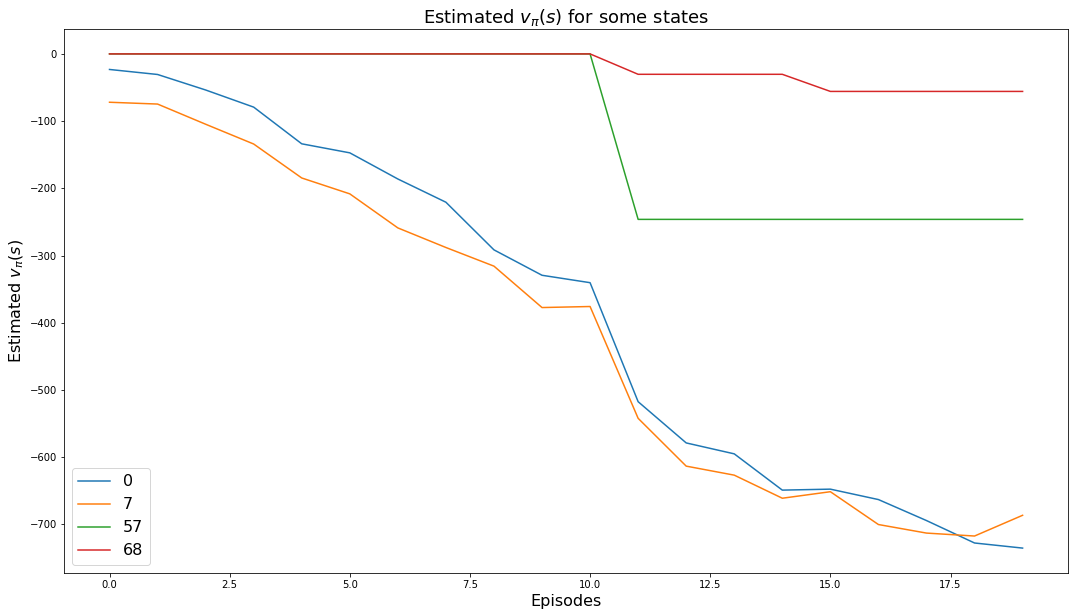

In [27]:
plt.rcParams["figure.figsize"] = (18,10)
for ms in monitored_states:
  plt.plot(monitored_state_values1[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

Here are some additional metrics:

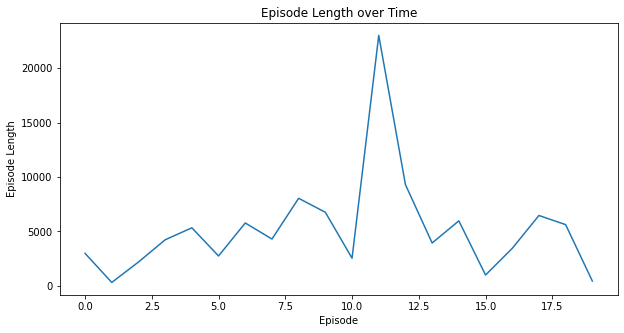

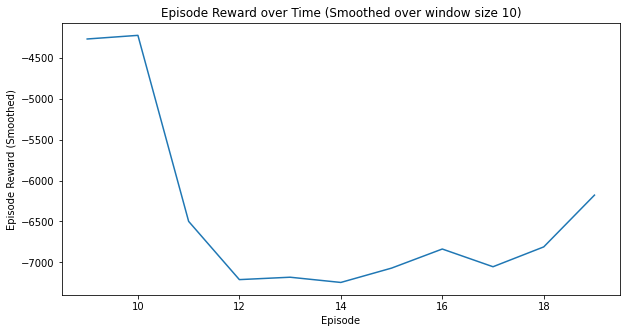

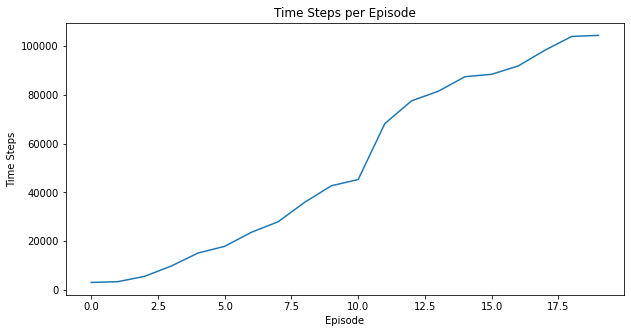

In [28]:
myplot.plot_episode_stats(stats);

To make a plot of the state-value function we reshape the values to align with the Windy Gridworld pattern.

In [29]:
# convert V1 to V1p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
V1p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  V1p[position] = V1[s]

In [30]:
V1p

{(0, 0): -735.1459031454285,
 (0, 1): -730.9210723890925,
 (0, 2): -748.20305259413,
 (0, 3): -754.9261025764922,
 (0, 4): -752.8787838171859,
 (0, 5): -750.0883665323886,
 (0, 6): -743.9117787359457,
 (0, 7): -686.3473071680427,
 (0, 8): -662.4342333214856,
 (0, 9): -657.5562656363784,
 (1, 0): -718.1124016107731,
 (1, 1): -731.8165301553454,
 (1, 2): -743.5612619011463,
 (1, 3): -749.0929971772642,
 (1, 4): -747.278666145852,
 (1, 5): -721.623343444135,
 (1, 6): -686.7081261934021,
 (1, 7): -724.3152993242904,
 (1, 8): -690.1043378911771,
 (1, 9): -629.1439695837937,
 (2, 0): -721.0189278360183,
 (2, 1): -726.3611748241806,
 (2, 2): -736.108040280805,
 (2, 3): -744.1853570649814,
 (2, 4): -727.6459474757083,
 (2, 5): -645.5264132122365,
 (2, 6): -658.855984783116,
 (2, 7): -698.0281822057283,
 (2, 8): -664.3786577812602,
 (2, 9): -524.8556599796428,
 (3, 0): -701.4558214932435,
 (3, 1): -701.3759709309548,
 (3, 2): -719.855350075502,
 (3, 3): -738.8169361136412,
 (3, 4): -724.4401572

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


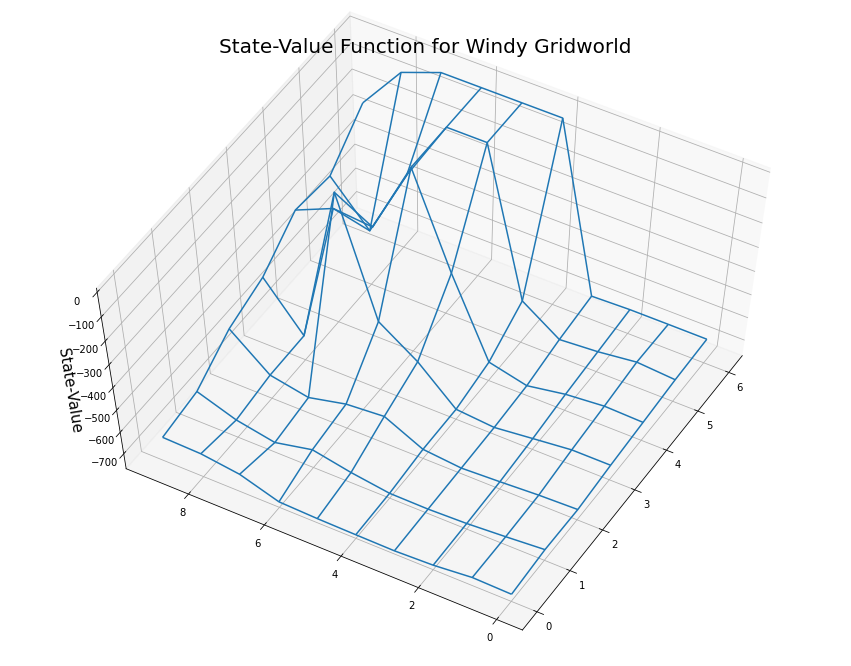

In [31]:
myplot.plot_state_value_surface(V1p, title='State-Value Function for Windy Gridworld', wireframe=True, azim=-150, elev=60);

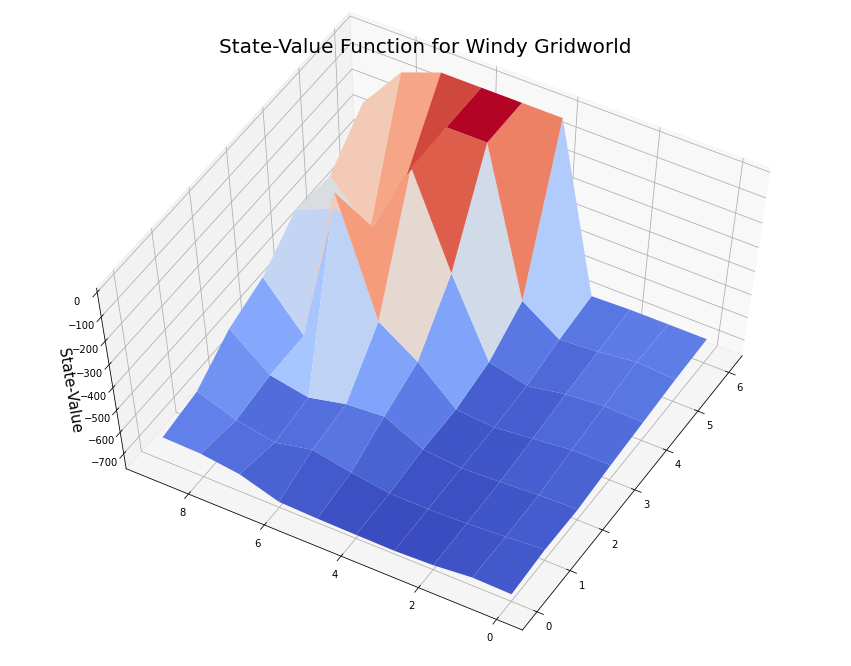

In [32]:
myplot.plot_state_value_surface(V1p, title='State-Value Function for Windy Gridworld', wireframe=False, azim=-150, elev=60);

In [33]:
# hide
# def plot_state_value_heatmap(V, title='State-Value Function'): #.
#   min_x = min(k[0] for k in V.keys())
#   max_x = max(k[0] for k in V.keys())
#   min_y = min(k[1] for k in V.keys())
#   max_y = max(k[1] for k in V.keys())
#   x_range = np.arange(min_x, max_x + 1)
#   y_range = np.arange(min_y, max_y + 1)
#   X, Y = np.meshgrid(x_range, y_range)
#   fig = plt.figure(figsize=(15, 12))
#   ax = fig.add_subplot(1, 1, 1)
#   ax.set_xlabel('')
#   ax.set_ylabel('')
#   # ax.set_zlabel('Value')
#   ax.set_title(title, fontsize=20)
#   Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X,Y]))
#   Z = np.transpose(Z)
#   im = ax.imshow(Z, cmap=cm.coolwarm)
#   ax.text(0, 3, 'S', ha="center", va="center", fontsize=40,
#     horizontalalignment='center',
#     verticalalignment='center')
#   ax.text(7, 3, 'G', ha="center", va="center", fontsize=40,
#     horizontalalignment='center',
#     verticalalignment='center')
#   fig.colorbar(im)

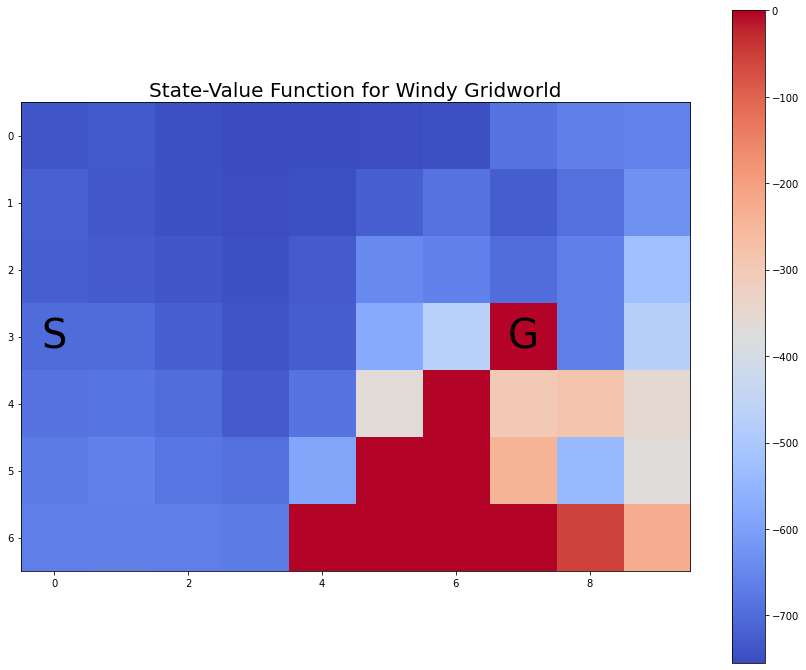

In [34]:
# plot_state_value_heatmap(V1p, title='State-Value Function for Windy Gridworld');
myplot.plot_state_value_heatmap_windy_gridworld(V1p, title='State-Value Function for Windy Gridworld');

### 5.6 Run 2

In [35]:
V2,stats,monitored_state_values2 = td_0_prediction(
  env, 
  n_episodes=200,
  alpha=0.5,
  monitored_states=monitored_states,
  diag=False)

Episode 200/200

In [36]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values2[ms][-1], V2[ms]

ms: 0


(-4193.810401393425, -4193.810401393425)

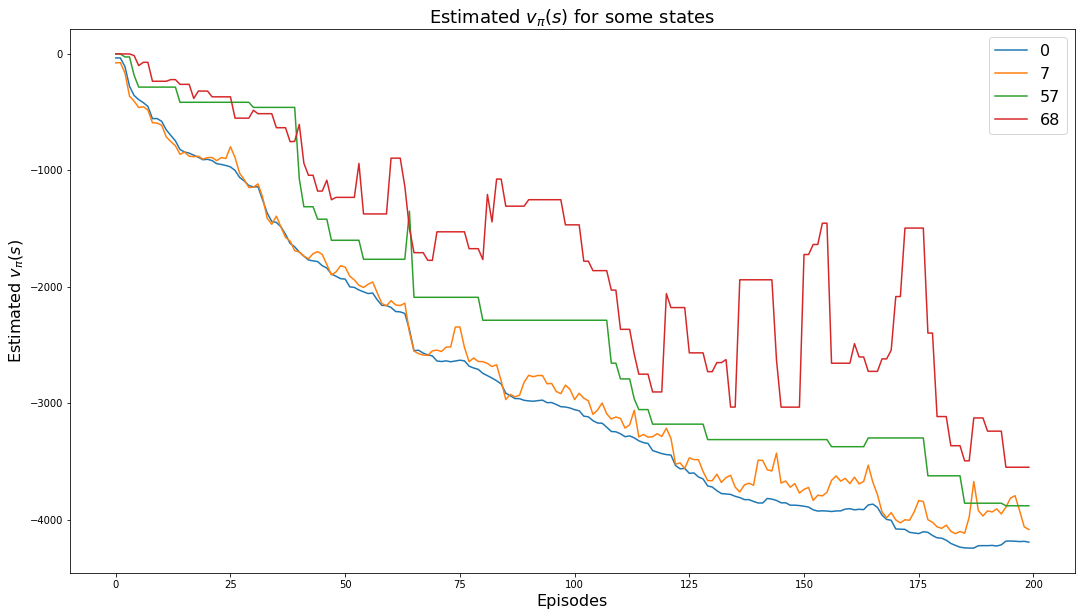

In [37]:
plt.rcParams["figure.figsize"] = (18,10)
for ms in monitored_states:
  plt.plot(monitored_state_values2[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

Here are some additional metrics:

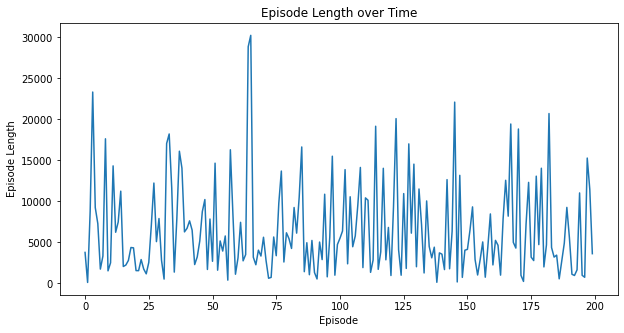

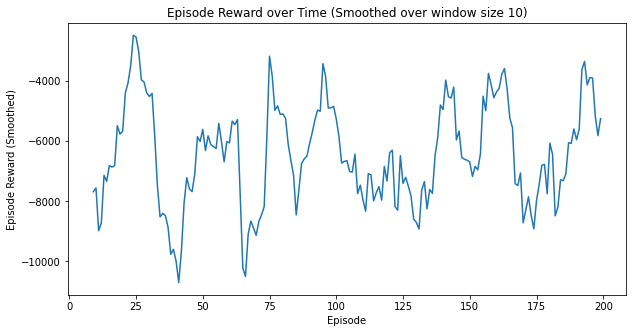

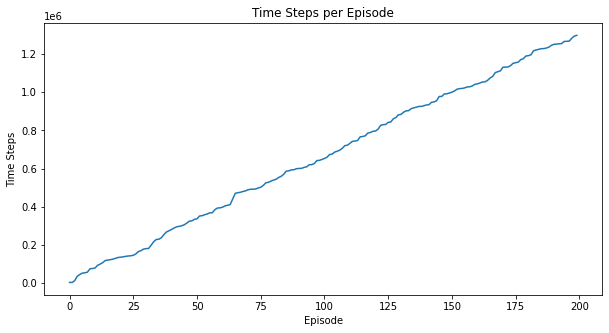

In [38]:
myplot.plot_episode_stats(stats);

In [39]:
# convert V2 to V2p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
V2p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  V2p[position] = V2[s]

In [40]:
V2p

{(0, 0): -4193.810401393425,
 (0, 1): -4193.814757777407,
 (0, 2): -4191.890300247405,
 (0, 3): -4185.298602492931,
 (0, 4): -4174.72733085042,
 (0, 5): -4147.26308505477,
 (0, 6): -4118.407005550107,
 (0, 7): -4085.405156242255,
 (0, 8): -4071.2953094442705,
 (0, 9): -4046.459316882357,
 (1, 0): -4191.019217298803,
 (1, 1): -4191.6556502288895,
 (1, 2): -4190.4299296322715,
 (1, 3): -4190.965173415778,
 (1, 4): -4180.658164880097,
 (1, 5): -4126.107376489743,
 (1, 6): -3987.0554972487753,
 (1, 7): -4071.2527793806516,
 (1, 8): -4057.6179390117704,
 (1, 9): -4021.9726305212557,
 (2, 0): -4186.732672802048,
 (2, 1): -4186.617107436847,
 (2, 2): -4187.14920440839,
 (2, 3): -4187.742698915825,
 (2, 4): -4173.760780122282,
 (2, 5): -4151.302795294076,
 (2, 6): -4043.2356769698185,
 (2, 7): -4065.931040123559,
 (2, 8): -4060.995750405103,
 (2, 9): -3998.1373273491854,
 (3, 0): -4181.435865523515,
 (3, 1): -4183.7105431386135,
 (3, 2): -4185.254196149683,
 (3, 3): -4167.789277506801,
 (3, 4)

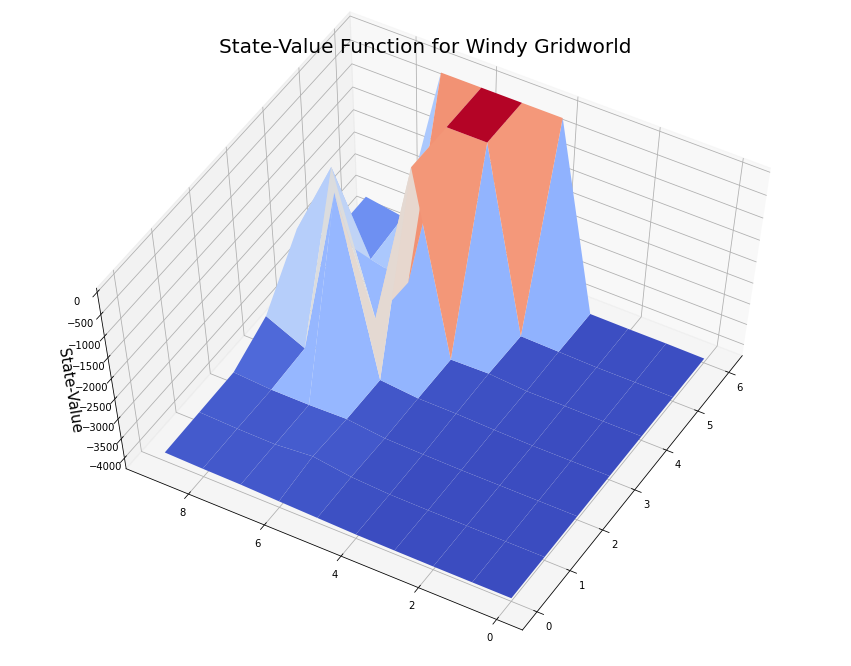

In [41]:
myplot.plot_state_value_surface(V2p, title='State-Value Function for Windy Gridworld', wireframe=False, azim=-150, elev=60);

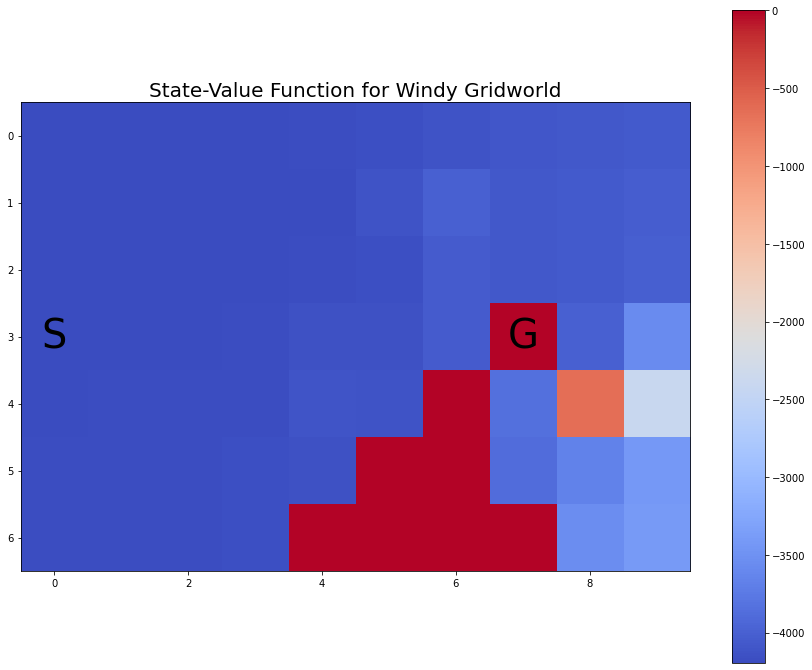

In [42]:
myplot.plot_state_value_heatmap_windy_gridworld(V2p, title='State-Value Function for Windy Gridworld');